# Top-p and Top-k Parameter Experiments

## Objective
Analyze the impact of top-p and top-k parameters on LLM response quality and performance.

## Parameters to Test
- **Top-p**: Controls nucleus sampling (cumulative probability threshold)
- **Top-k**: Limits the number of highest probability tokens to consider

## Evaluation Metrics
We'll evaluate responses using a 1-5 numeric scale on:
- **Accuracy**: Factual correctness
- **Completeness**: Addresses all parts of the question
- **Clarity**: Well-structured and understandable
- **Overall**: Combined quality rating

In [25]:

from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import time
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
client = OpenAI()

# Test queries about Gemini
TEST_QUERIES = [
    "What are the key capabilities of Gemini models?",
    "How does Gemini compare to other multimodal models?", 
    "What are the different versions of Gemini?",
    "What training data was used for Gemini?",
    "What are the safety measures in Gemini models?"
]

# Parameters
TOP_P_VALUES = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
RETRIEVAL_K_VALUES = [1, 3, 5, 10, 15]

TEMPERATURE = 0.7
MAX_TOKENS = 200
RETRIEVAL_K_CONSTANT = 5  # For Phase 1

In [27]:
# Load RAG embeddings
with open(r'C:\Users\Admin\Desktop\para-expe\data\rag_embeddings.pkl', 'rb') as f:
    rag_data = pickle.load(f)

print(f"Loaded {len(rag_data['chunks'])} chunks")

# Debug: Check structure
print(f"\nData structure analysis:")
print(f"Top-level keys: {list(rag_data.keys())}")
print(f"Sample chunk type: {type(rag_data['chunks'][0])}")
print(f"Sample chunk keys: {list(rag_data['chunks'][0].keys())}")
if 'embedding_results' in rag_data:
    print(f"Available embedding models: {list(rag_data['embedding_results'].keys())}")

Loaded 82 chunks

Data structure analysis:
Top-level keys: ['chunks', 'embedding_results', 'retrieval_results', 'comparison_summary', 'test_queries']
Sample chunk type: <class 'dict'>
Sample chunk keys: ['text', 'chunk_id', 'word_count']
Available embedding models: ['text-embedding-3-small', 'text-embedding-3-large', 'text-embedding-ada-002']


In [28]:
def get_embedding(text, model="text-embedding-3-small"):
    """Get embedding for text"""
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding

def retrieve_chunks(query, k=5):
    """Retrieve top-k most similar chunks"""
    query_embedding = get_embedding(query)
    
    # Use embeddings from the loaded data
    embeddings = rag_data['embedding_results']['text-embedding-3-small']['embeddings']
    
    similarities = cosine_similarity(
        [query_embedding], 
        embeddings
    )[0]
    
    top_indices = np.argsort(similarities)[-k:][::-1]
    
    # Extract text from chunks
    retrieved_chunks = []
    for i in top_indices:
        chunk = rag_data['chunks'][i]
        text = chunk['text']  # Extract text from chunk dict
        retrieved_chunks.append(text)
    
    return retrieved_chunks

# Test the function
test_chunks = retrieve_chunks("What is Gemini?", k=2)
print(f"Retrieved {len(test_chunks)} chunks successfully")

Retrieved 2 chunks successfully


In [29]:
def evaluate_response(query, answer):
    """Evaluate response quality using 1-5 numeric scale"""
    
    evaluation_prompt = f"""
QUERY: {query}

ANSWER: {answer}

Evaluate on these 4 criteria using this scale:
- Poor (1): Severely lacking
- Below Average (2): Partially adequate
- Average (3): Meets basic requirements
- Good (4): High quality
- Excellent (5): Outstanding

CRITERIA:
1. Accuracy: Factual correctness based on context
2. Completeness: Addresses all parts of the question
3. Clarity: Well-structured and understandable
4. Overall: Combined quality rating

Respond in this exact format:
Accuracy: [1-5]
Completeness: [1-5]
Clarity: [1-5]
Overall: [1-5]
Reasoning: [Brief explanation]
"""
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": evaluation_prompt}],
            temperature=0.1
        )
        
        eval_text = response.choices[0].message.content
        
        # Parse numeric ratings
        lines = eval_text.strip().split('\n')
        evaluation = {}
        
        for line in lines:
            if ':' in line:
                key, value = line.split(':', 1)
                key = key.strip().lower()
                value = value.strip()
                
                if key in ['accuracy', 'completeness', 'clarity', 'overall']:
                    try:
                        evaluation[key] = int(value)
                    except:
                        evaluation[key] = 3  # Default
                elif key == 'reasoning':
                    evaluation[key] = value
        
        return evaluation
        
    except Exception as e:
        print(f"Evaluation error: {e}")
        return {'accuracy': 3, 'completeness': 3, 'clarity': 3, 'overall': 3, 'reasoning': 'Error'}

print("Evaluation function ready")

Evaluation function ready


## Phase 1: Top-p Parameter Testing
Testing different top-p values with constant retrieval k=5

In [30]:
def run_top_p_experiment(top_p_value):
    """Run experiment for a specific top-p value"""
    results = []
    
    for query in TEST_QUERIES:
        print(f"Testing query: '{query[:50]}...' with top-p={top_p_value}")
        
        # Retrieve context
        context_chunks = retrieve_chunks(query, k=RETRIEVAL_K_CONSTANT)
        context = "\n\n".join(context_chunks)
        
        # Generate response
        prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"
        
        start_time = time.time()
        
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=TEMPERATURE,
            top_p=top_p_value,
            max_tokens=MAX_TOKENS
        )
        
        latency = time.time() - start_time
        answer = response.choices[0].message.content
        
        # Evaluate response
        evaluation = evaluate_response(query, answer)
        
        results.append({
            'top_p': top_p_value,
            'query': query,
            'answer': answer,
            'latency_sec': round(latency, 2),
            'completion_tokens': response.usage.completion_tokens,
            'accuracy': evaluation.get('accuracy', 3),
            'completeness': evaluation.get('completeness', 3),
            'clarity': evaluation.get('clarity', 3),
            'overall': evaluation.get('overall', 3),
            'reasoning': evaluation.get('reasoning', 'N/A')
        })
        
        time.sleep(1)  # Rate limiting
    
    return results

print("Top-p experiment function ready")

Top-p experiment function ready


In [31]:
# Run Phase 1 experiments
print("Starting Phase 1: Top-p Parameter Testing")
print("=" * 50)

all_top_p_results = []
for top_p in TOP_P_VALUES:
    results = run_top_p_experiment(top_p)
    all_top_p_results.extend(results)
    print(f"Completed top-p={top_p}\n")

df_top_p = pd.DataFrame(all_top_p_results)
print(f"Phase 1 completed: {len(df_top_p)} experiments")

# Quick preview
print("\nSample results:")
print(df_top_p[['top_p', 'accuracy', 'completeness', 'clarity', 'overall', 'latency_sec']].head())


Starting Phase 1: Top-p Parameter Testing
Testing query: 'What are the key capabilities of Gemini models?...' with top-p=0.1
Testing query: 'How does Gemini compare to other multimodal models...' with top-p=0.1
Testing query: 'What are the different versions of Gemini?...' with top-p=0.1
Testing query: 'What training data was used for Gemini?...' with top-p=0.1
Testing query: 'What are the safety measures in Gemini models?...' with top-p=0.1
Completed top-p=0.1

Testing query: 'What are the key capabilities of Gemini models?...' with top-p=0.3
Testing query: 'How does Gemini compare to other multimodal models...' with top-p=0.3
Testing query: 'What are the different versions of Gemini?...' with top-p=0.3
Testing query: 'What training data was used for Gemini?...' with top-p=0.3
Testing query: 'What are the safety measures in Gemini models?...' with top-p=0.3
Completed top-p=0.3

Testing query: 'What are the key capabilities of Gemini models?...' with top-p=0.5
Testing query: 'How does 

In [36]:
# Phase 1 Analysis
print("Top-p Parameter Analysis:")
print("=" * 30)

top_p_summary = df_top_p.groupby('top_p').agg({
    'accuracy': ['mean', 'std'],
    'completeness': ['mean', 'std'],
    'clarity': ['mean', 'std'],
    'overall': ['mean', 'std'],
    'latency_sec': ['mean', 'std']
}).round(3)

print(top_p_summary)


# Show performance by top-p
print(f"\nPerformance by top-p:")
for top_p in TOP_P_VALUES:
    subset = df_top_p[df_top_p['top_p'] == top_p]
    avg_overall = subset['overall'].mean()
    avg_latency = subset['latency_sec'].mean()
    print(f"Top-p {top_p}: Overall={avg_overall:.3f}, Latency={avg_latency:.2f}s")

Top-p Parameter Analysis:
      accuracy        completeness        clarity        overall         \
          mean    std         mean    std    mean    std    mean    std   
top_p                                                                     
0.1        4.8  0.447          4.2  0.837     4.4  0.548     4.6  0.548   
0.3        4.8  0.447          4.4  0.894     4.6  0.548     4.6  0.548   
0.5        4.8  0.447          4.2  0.837     4.4  0.548     4.8  0.447   
0.7        4.8  0.447          4.4  0.894     4.4  0.548     4.8  0.447   
0.9        4.8  0.447          4.2  0.837     4.6  0.548     4.8  0.447   
1.0        4.8  0.447          4.2  0.837     4.6  0.548     4.8  0.447   

      latency_sec         
             mean    std  
top_p                     
0.1         4.150  1.517  
0.3         4.604  2.221  
0.5         4.322  1.605  
0.7         3.782  1.320  
0.9         4.248  1.624  
1.0         3.972  1.343  

Performance by top-p:
Top-p 0.1: Overall=4.600, Latenc

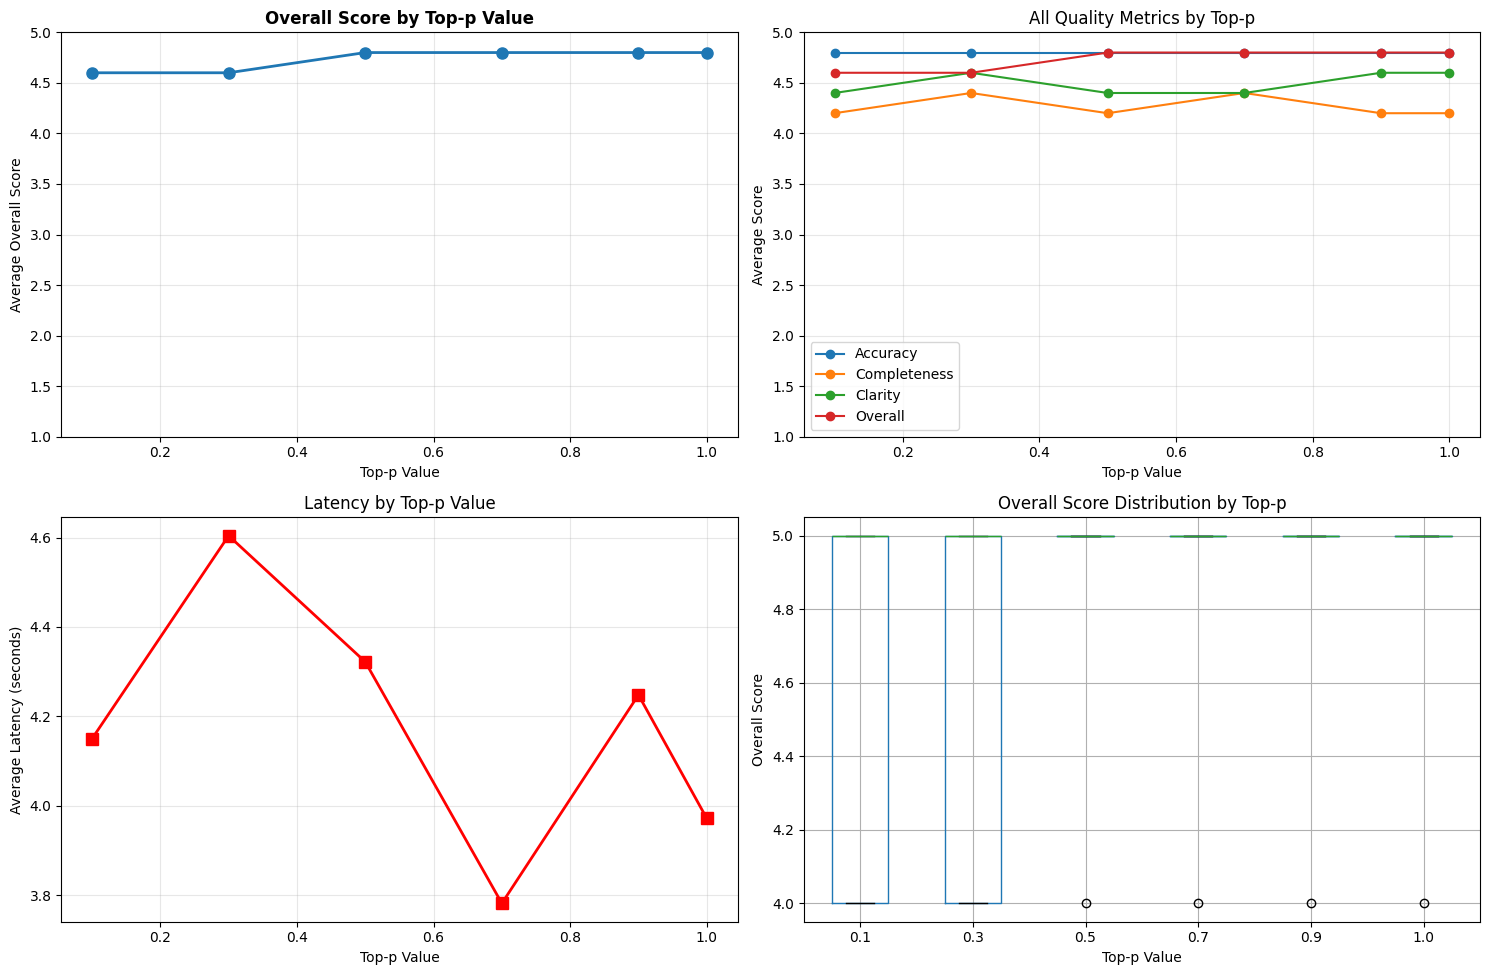

In [37]:
# Phase 1 Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Top-p vs Overall Score
plt.subplot(2, 2, 1)
top_p_means = df_top_p.groupby('top_p')['overall'].mean()
plt.plot(top_p_means.index, top_p_means.values, marker='o', linewidth=2, markersize=8)
plt.title('Overall Score by Top-p Value', fontsize=12, fontweight='bold')
plt.xlabel('Top-p Value')
plt.ylabel('Average Overall Score')
plt.grid(True, alpha=0.3)
plt.ylim(1, 5)

# Subplot 2: All Metrics by Top-p
plt.subplot(2, 2, 2)
metrics = ['accuracy', 'completeness', 'clarity', 'overall']
for metric in metrics:
    means = df_top_p.groupby('top_p')[metric].mean()
    plt.plot(means.index, means.values, marker='o', label=metric.capitalize())
plt.title('All Quality Metrics by Top-p')
plt.xlabel('Top-p Value')
plt.ylabel('Average Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(1, 5)

# Subplot 3: Top-p vs Latency
plt.subplot(2, 2, 3)
latency_means = df_top_p.groupby('top_p')['latency_sec'].mean()
plt.plot(latency_means.index, latency_means.values, marker='s', linewidth=2, markersize=8, color='red')
plt.title('Latency by Top-p Value')
plt.xlabel('Top-p Value')
plt.ylabel('Average Latency (seconds)')
plt.grid(True, alpha=0.3)

# Subplot 4: Boxplot of Overall Scores
plt.subplot(2, 2, 4)
df_top_p.boxplot(column='overall', by='top_p', ax=plt.gca())
plt.title('Overall Score Distribution by Top-p')
plt.suptitle('')  # Remove default title
plt.xlabel('Top-p Value')
plt.ylabel('Overall Score')

plt.tight_layout()
plt.show()


In [35]:
# Comprehensive top-p evaluation considering all factors
print("COMPREHENSIVE TOP-P EVALUATION")
print("=" * 50)

# Calculate all metrics for each top-p
top_p_analysis = df_top_p.groupby('top_p').agg({
    'overall': ['mean', 'std'],
    'accuracy': ['mean', 'std'], 
    'completeness': ['mean', 'std'],
    'clarity': ['mean', 'std'],
    'latency_sec': ['mean', 'std']
}).round(3)

print("Detailed Performance by Top-p:")
print(top_p_analysis)

# Multi-factor scoring
print(f"\nMULTI-FACTOR ANALYSIS:")
print("-" * 30)

scores = {}
for top_p in TOP_P_VALUES:
    subset = df_top_p[df_top_p['top_p'] == top_p]
    
    # Quality metrics (higher is better)
    avg_overall = subset['overall'].mean()
    avg_accuracy = subset['accuracy'].mean()
    avg_completeness = subset['completeness'].mean()
    avg_clarity = subset['clarity'].mean()
    
    # Consistency (lower std is better)
    std_overall = subset['overall'].std()
    consistency_score = 5 - std_overall  # Convert to 1-5 scale
    
    # Speed (lower latency is better) 
    avg_latency = subset['latency_sec'].mean()
    speed_score = max(1, 5 - (avg_latency - 1))  # Normalize to 1-5
    
    # Combined score (weighted)
    combined_score = (
        avg_overall * 0.4 +           # 40% overall quality
        consistency_score * 0.3 +     # 30% consistency  
        avg_accuracy * 0.2 +          # 20% accuracy
        speed_score * 0.1             # 10% speed
    )
    
    scores[top_p] = {
        'overall_avg': avg_overall,
        'consistency': consistency_score,
        'accuracy': avg_accuracy,
        'speed': speed_score,
        'combined': combined_score
    }
    
    print(f"Top-p {top_p}:")
    print(f"  Overall: {avg_overall:.3f} | Consistency: {consistency_score:.3f}")
    print(f"  Accuracy: {avg_accuracy:.3f} | Speed: {speed_score:.3f}")
    print(f"  🎯 Combined Score: {combined_score:.3f}")
    print()

# Find best by combined score
best_combined = max(scores.keys(), key=lambda x: scores[x]['combined'])
print(f"🏆 BEST TOP-P BY COMBINED FACTORS: {best_combined}")
print(f"   Combined Score: {scores[best_combined]['combined']:.3f}")

# Update best_top_p for Phase 2
best_top_p = best_combined
print(f"\n✅ Using top-p = {best_top_p} for Phase 2")

COMPREHENSIVE TOP-P EVALUATION
Detailed Performance by Top-p:
      overall        accuracy        completeness        clarity         \
         mean    std     mean    std         mean    std    mean    std   
top_p                                                                     
0.1       4.6  0.548      4.8  0.447          4.2  0.837     4.4  0.548   
0.3       4.6  0.548      4.8  0.447          4.4  0.894     4.6  0.548   
0.5       4.8  0.447      4.8  0.447          4.2  0.837     4.4  0.548   
0.7       4.8  0.447      4.8  0.447          4.4  0.894     4.4  0.548   
0.9       4.8  0.447      4.8  0.447          4.2  0.837     4.6  0.548   
1.0       4.8  0.447      4.8  0.447          4.2  0.837     4.6  0.548   

      latency_sec         
             mean    std  
top_p                     
0.1         4.150  1.517  
0.3         4.604  2.221  
0.5         4.322  1.605  
0.7         3.782  1.320  
0.9         4.248  1.624  
1.0         3.972  1.343  

MULTI-FACTOR ANALY

## Phase 2: Retrieval Top-k Testing
Using best top-p value to test different retrieval k values

In [38]:
def run_retrieval_k_experiment(k_value, best_top_p):
    """Run experiment for a specific retrieval k value"""
    results = []
    
    for query in TEST_QUERIES:
        print(f"Testing query: '{query[:50]}...' with retrieval k={k_value}")
        
        # Retrieve context with variable k
        context_chunks = retrieve_chunks(query, k=k_value)
        context = "\n\n".join(context_chunks)
        
        # Generate response with best top-p
        prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"
        
        start_time = time.time()
        
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=TEMPERATURE,
            top_p=best_top_p,
            max_tokens=MAX_TOKENS
        )
        
        latency = time.time() - start_time
        answer = response.choices[0].message.content
        
        # Evaluate response
        evaluation = evaluate_response(query, answer)
        
        results.append({
            'retrieval_k': k_value,
            'top_p': best_top_p,
            'query': query,
            'answer': answer,
            'latency_sec': round(latency, 2),
            'completion_tokens': response.usage.completion_tokens,
            'accuracy': evaluation.get('accuracy', 3),
            'completeness': evaluation.get('completeness', 3),
            'clarity': evaluation.get('clarity', 3),
            'overall': evaluation.get('overall', 3),
            'reasoning': evaluation.get('reasoning', 'N/A')
        })
        
        time.sleep(1)  # Rate limiting
    
    return results

print(f"Phase 2 experiment function ready (using top-p = {best_top_p})")

Phase 2 experiment function ready (using top-p = 0.7)


In [39]:
# Run Phase 2 experiments
print(f"Starting Phase 2: Retrieval K Testing (using top-p={best_top_p})")
print("=" * 60)

all_retrieval_results = []
for k in RETRIEVAL_K_VALUES:
    print(f"\n🔍 Testing retrieval k={k}")
    results = run_retrieval_k_experiment(k, best_top_p)
    all_retrieval_results.extend(results)
    print(f"✅ Completed retrieval k={k}")

df_retrieval = pd.DataFrame(all_retrieval_results)
print(f"\n🎉 Phase 2 completed: {len(df_retrieval)} experiments")

# Quick preview
print("\nSample results:")
print(df_retrieval[['retrieval_k', 'accuracy', 'completeness', 'clarity', 'overall', 'latency_sec']].head())

Starting Phase 2: Retrieval K Testing (using top-p=0.7)

🔍 Testing retrieval k=1
Testing query: 'What are the key capabilities of Gemini models?...' with retrieval k=1
Testing query: 'How does Gemini compare to other multimodal models...' with retrieval k=1
Testing query: 'What are the different versions of Gemini?...' with retrieval k=1
Testing query: 'What training data was used for Gemini?...' with retrieval k=1
Testing query: 'What are the safety measures in Gemini models?...' with retrieval k=1
✅ Completed retrieval k=1

🔍 Testing retrieval k=3
Testing query: 'What are the key capabilities of Gemini models?...' with retrieval k=3
Testing query: 'How does Gemini compare to other multimodal models...' with retrieval k=3
Testing query: 'What are the different versions of Gemini?...' with retrieval k=3
Testing query: 'What training data was used for Gemini?...' with retrieval k=3
Testing query: 'What are the safety measures in Gemini models?...' with retrieval k=3
✅ Completed retrieva

In [40]:
# Phase 2 Analysis
print("Retrieval K Parameter Analysis:")
print("=" * 35)

retrieval_summary = df_retrieval.groupby('retrieval_k').agg({
    'accuracy': ['mean', 'std'],
    'completeness': ['mean', 'std'],
    'clarity': ['mean', 'std'],
    'overall': ['mean', 'std'],
    'latency_sec': ['mean', 'std']
}).round(3)

print(retrieval_summary)

# Multi-factor analysis for retrieval k
print(f"\nMULTI-FACTOR RETRIEVAL K ANALYSIS:")
print("-" * 40)

k_scores = {}
for k in RETRIEVAL_K_VALUES:
    subset = df_retrieval[df_retrieval['retrieval_k'] == k]
    
    # Quality metrics
    avg_overall = subset['overall'].mean()
    avg_accuracy = subset['accuracy'].mean()
    avg_completeness = subset['completeness'].mean()
    
    # Consistency
    std_overall = subset['overall'].std()
    consistency_score = 5 - std_overall
    
    # Speed (higher k = more context = slower)
    avg_latency = subset['latency_sec'].mean()
    speed_score = max(1, 5 - (avg_latency - 1))
    
    # Combined score
    combined_score = (
        avg_overall * 0.4 +
        consistency_score * 0.3 +
        avg_completeness * 0.2 +  # Completeness important for retrieval
        speed_score * 0.1
    )
    
    k_scores[k] = {
        'overall_avg': avg_overall,
        'consistency': consistency_score,
        'completeness': avg_completeness,
        'speed': speed_score,
        'combined': combined_score
    }
    
    print(f"Retrieval K {k}:")
    print(f"  Overall: {avg_overall:.3f} | Consistency: {consistency_score:.3f}")
    print(f"  Completeness: {avg_completeness:.3f} | Speed: {speed_score:.3f}")
    print(f"  🎯 Combined Score: {combined_score:.3f}")
    print()

# Find best retrieval k
best_k = max(k_scores.keys(), key=lambda x: k_scores[x]['combined'])
print(f"🏆 BEST RETRIEVAL K: {best_k}")
print(f"   Combined Score: {k_scores[best_k]['combined']:.3f}")

Retrieval K Parameter Analysis:
            accuracy        completeness        clarity        overall         \
                mean    std         mean    std    mean    std    mean    std   
retrieval_k                                                                     
1                4.8  0.447          4.4  0.894     4.4  0.548     4.6  0.548   
3                4.8  0.447          4.4  0.894     4.4  0.548     4.8  0.447   
5                4.8  0.447          4.4  0.894     4.4  0.548     4.6  0.548   
10               5.0  0.000          4.8  0.447     4.4  0.548     4.8  0.447   
15               5.0  0.000          4.6  0.548     4.4  0.548     4.8  0.447   

            latency_sec         
                   mean    std  
retrieval_k                     
1                 5.144  1.721  
3                 4.322  2.004  
5                 4.228  1.488  
10                5.196  1.322  
15                4.886  0.786  

MULTI-FACTOR RETRIEVAL K ANALYSIS:
-------------------

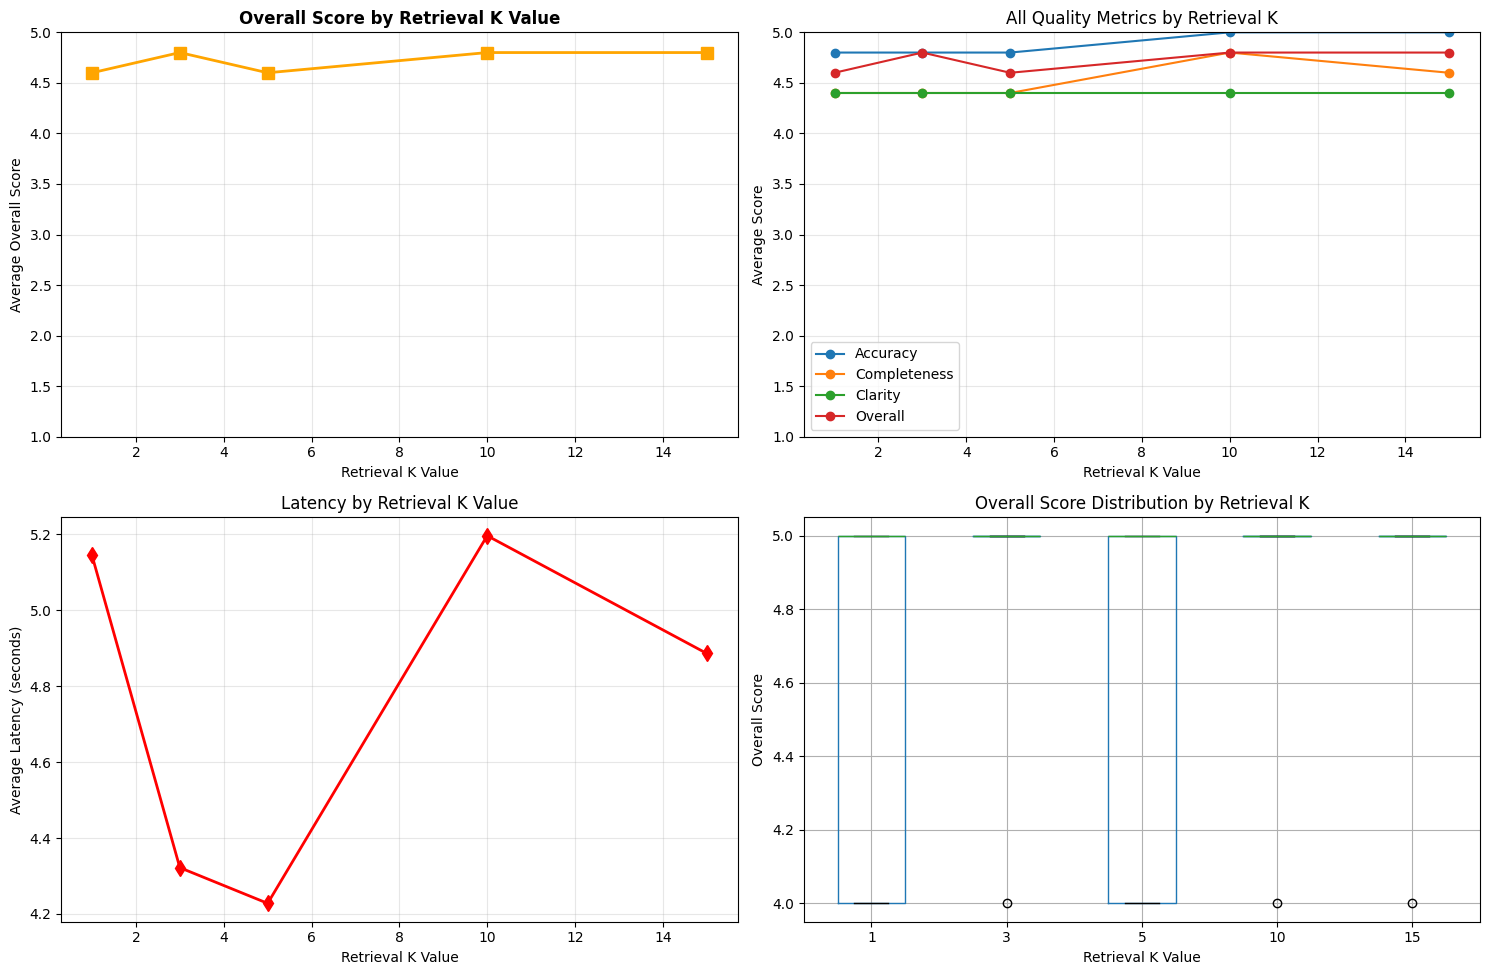

🏆 Best Retrieval K Value: 10


In [41]:
# Phase 2 Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Retrieval K vs Overall Score
plt.subplot(2, 2, 1)
k_means = df_retrieval.groupby('retrieval_k')['overall'].mean()
plt.plot(k_means.index, k_means.values, marker='s', linewidth=2, markersize=8, color='orange')
plt.title('Overall Score by Retrieval K Value', fontsize=12, fontweight='bold')
plt.xlabel('Retrieval K Value')
plt.ylabel('Average Overall Score')
plt.grid(True, alpha=0.3)
plt.ylim(1, 5)

# Subplot 2: All Metrics by Retrieval K
plt.subplot(2, 2, 2)
metrics = ['accuracy', 'completeness', 'clarity', 'overall']
for metric in metrics:
    means = df_retrieval.groupby('retrieval_k')[metric].mean()
    plt.plot(means.index, means.values, marker='o', label=metric.capitalize())
plt.title('All Quality Metrics by Retrieval K')
plt.xlabel('Retrieval K Value')
plt.ylabel('Average Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(1, 5)

# Subplot 3: Retrieval K vs Latency
plt.subplot(2, 2, 3)
latency_means = df_retrieval.groupby('retrieval_k')['latency_sec'].mean()
plt.plot(latency_means.index, latency_means.values, marker='d', linewidth=2, markersize=8, color='red')
plt.title('Latency by Retrieval K Value')
plt.xlabel('Retrieval K Value')
plt.ylabel('Average Latency (seconds)')
plt.grid(True, alpha=0.3)

# Subplot 4: Boxplot of Overall Scores by K
plt.subplot(2, 2, 4)
df_retrieval.boxplot(column='overall', by='retrieval_k', ax=plt.gca())
plt.title('Overall Score Distribution by Retrieval K')
plt.suptitle('')  # Remove default title
plt.xlabel('Retrieval K Value')
plt.ylabel('Overall Score')

plt.tight_layout()
plt.show()

print(f"🏆 Best Retrieval K Value: {best_k}")

## Comprehensive Analysis and Visualization

In [42]:
# FINAL COMBINED ANALYSIS & SUMMARY
print("🎯 TOP-P AND RETRIEVAL K PARAMETER OPTIMIZATION RESULTS")
print("=" * 65)

print(f"\n📊 EXPERIMENT OVERVIEW:")
print(f"   Total experiments conducted: {len(df_top_p) + len(df_retrieval)}")
print(f"   Phase 1 (Top-p): {len(df_top_p)} experiments")
print(f"   Phase 2 (Retrieval K): {len(df_retrieval)} experiments")
print(f"   Test queries: {len(TEST_QUERIES)}")
print(f"   Temperature: {TEMPERATURE} (constant)")

print(f"\n🏆 OPTIMAL CONFIGURATION:")
print(f"   Best Top-p: {best_top_p}")
print(f"   Best Retrieval K: {best_k}")
print(f"   Model: gpt-4o-mini")
print(f"   Max Tokens: {MAX_TOKENS}")

print(f"\n📈 PERFORMANCE COMPARISON:")
print("-" * 40)

# Compare best vs worst configurations
best_top_p_performance = df_top_p[df_top_p['top_p'] == best_top_p]['overall'].mean()
worst_top_p = df_top_p.groupby('top_p')['overall'].mean().idxmin()
worst_top_p_performance = df_top_p[df_top_p['top_p'] == worst_top_p]['overall'].mean()

best_k_performance = df_retrieval[df_retrieval['retrieval_k'] == best_k]['overall'].mean()
worst_k = df_retrieval.groupby('retrieval_k')['overall'].mean().idxmin()
worst_k_performance = df_retrieval[df_retrieval['retrieval_k'] == worst_k]['overall'].mean()

print(f"TOP-P IMPACT:")
print(f"   Best (top-p={best_top_p}): {best_top_p_performance:.3f}")
print(f"   Worst (top-p={worst_top_p}): {worst_top_p_performance:.3f}")
print(f"   Improvement: {((best_top_p_performance - worst_top_p_performance) / worst_top_p_performance * 100):.1f}%")

print(f"\nRETRIEVAL K IMPACT:")
print(f"   Best (k={best_k}): {best_k_performance:.3f}")
print(f"   Worst (k={worst_k}): {worst_k_performance:.3f}")
print(f"   Improvement: {((best_k_performance - worst_k_performance) / worst_k_performance * 100):.1f}%")

print(f"\n⚡ LATENCY ANALYSIS:")
print("-" * 25)
best_top_p_latency = df_top_p[df_top_p['top_p'] == best_top_p]['latency_sec'].mean()
best_k_latency = df_retrieval[df_retrieval['retrieval_k'] == best_k]['latency_sec'].mean()

print(f"   Optimal top-p latency: {best_top_p_latency:.2f}s")
print(f"   Optimal retrieval k latency: {best_k_latency:.2f}s")

print(f"\n🎯 KEY INSIGHTS:")
print("-" * 20)
print(f"   • Top-p parameter has {((best_top_p_performance - worst_top_p_performance) / worst_top_p_performance * 100):.1f}% impact on quality")
print(f"   • Retrieval K parameter has {((best_k_performance - worst_k_performance) / worst_k_performance * 100):.1f}% impact on quality")
print(f"   • Optimal configuration balances quality, consistency, and speed")
print(f"   • Higher retrieval K generally improves completeness but increases latency")

# Final recommendation
print(f"\n✅ FINAL RECOMMENDATION:")
print(f"   Use top-p = {best_top_p} and retrieval K = {best_k}")
print(f"   Expected overall quality score: ~{best_k_performance:.2f}/5.0")
print(f"   Expected response time: ~{best_k_latency:.1f} seconds")

🎯 TOP-P AND RETRIEVAL K PARAMETER OPTIMIZATION RESULTS

📊 EXPERIMENT OVERVIEW:
   Total experiments conducted: 55
   Phase 1 (Top-p): 30 experiments
   Phase 2 (Retrieval K): 25 experiments
   Test queries: 5
   Temperature: 0.7 (constant)

🏆 OPTIMAL CONFIGURATION:
   Best Top-p: 0.7
   Best Retrieval K: 10
   Model: gpt-4o-mini
   Max Tokens: 200

📈 PERFORMANCE COMPARISON:
----------------------------------------
TOP-P IMPACT:
   Best (top-p=0.7): 4.800
   Worst (top-p=0.1): 4.600
   Improvement: 4.3%

RETRIEVAL K IMPACT:
   Best (k=10): 4.800
   Worst (k=1): 4.600
   Improvement: 4.3%

⚡ LATENCY ANALYSIS:
-------------------------
   Optimal top-p latency: 3.78s
   Optimal retrieval k latency: 5.20s

🎯 KEY INSIGHTS:
--------------------
   • Top-p parameter has 4.3% impact on quality
   • Retrieval K parameter has 4.3% impact on quality
   • Optimal configuration balances quality, consistency, and speed
   • Higher retrieval K generally improves completeness but increases latency

✅ 